# Q1 Model Performance

##### A very common question in every machine learning problem is: how many data samples do we need to model the system behaviour adequately. Unfortunately, just like many other topics in machine learning, there is no straight answer. In many toy problems presented in textbooks, a classification problem is solved with only 50-100 data points. In real world problems, a classification problem may be very difficult even with millions of data points.

##### Generally, the model performance depends on the following factors:
1. Are the classes easily separated or they are pretty mixed? Are they separated linearly or non-linearly? Is a linear or non-linear model used?
2. The features quality. Do they carry information with respect to the output/class? More features does not necessarily mean better performance. The famous quote ”Garbage in, garbage out” is used to describe uninformative features.
3. The number of data points. Intuitively, more data points lead to better performance. But after some point, it is expected that the increase in model performance diminishes.

##### The last point is the subject of this section. From a business perspective, you want to know how many samples you need to model the clients behaviour adequately. This information is crucial when the conditions change and you may want to re-fit your model.

##### For example, with Covid-19 the clients behaviour changed dramatically. Let’s assume that you are at the beginning of Covid-19 in March 2020 and your manager is asking you to re-fit the retail response problem you solved in Assignment #5 (apologies for putting you mentally back at the beginning of Covid-19, we are almost out of it). The question that comes with this request is: **how many data points** do you need to re-fit the model with adequate performance?

##### You know that generally more data points means better performance, but you cannot wait for too long to collect new data post-March 2020 because your business will not have a reliable model for as long as you collect data. A similar situation may appear in an industrial setting, let’s say after the annual maintenance of a machine or a reactor. How many data points do you need to model the machine or reactor behaviour after the maintenance?

# 1.1 Dataset size v/s Model Performance

Here, you will quantify the relationship between the dataset size and the model performance. Essentially, you will answer the question: how much data is enough to model client behaviour? In order to do this, you will pick the best single tree model you created in **Assignment #5** and evaluate it with datasets of different sizes using the monthly features you created in **Assignment #3**.

In [1]:
# Import Libraries and relevent settings
import pandas as pd
import numpy as np
import seaborn as sns
import imputena as imp
import missingno as mno
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator
from sklearn import preprocessing as prep
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import product

matplotlib.rcParams['figure.figsize'] = (16, 16)
matplotlib.rcParams.update({'font.size': 10})

# from bokeh.models import ColumnDataSource, LabelSet, Arrow, NormalHead, OpenHead, VeeHead, ColorBar
# from bokeh.plotting import figure, output_file, show
# from bokeh.transform import linear_cmap
# from bokeh.palettes import RdBu

In [2]:
Retail_Data_Response = pd.read_csv('Retail_Data_Response.csv')

In [3]:
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')

In [4]:
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')

In [5]:
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

In [6]:
mth_rolling_features = mth_rolling_features.drop(columns = 'Unnamed: 0')
mth_day_counts = mth_day_counts.drop(columns = 'Unnamed: 0')
days_since_last_txn = days_since_last_txn.drop(columns = 'Unnamed: 0')

In [7]:
a = mth_rolling_features.merge(mth_day_counts, left_on = ['customer_id', 'ME DT'], right_on = ['customer_id', 'ME DT'])
b = a.merge(days_since_last_txn, left_on = ['customer_id', 'ME DT'], right_on = ['customer_id', 'ME DT'])
monthly_features_outputs = b.merge(Retail_Data_Response, how = 'right', left_on = 'customer_id', right_on = 'customer_id')
monthly_features_outputs = monthly_features_outputs.set_index(['customer_id','ME DT'])
monthly_features_outputs

mth_txn_amt_sum  mth_txn_amt_count  amt sum 3M  \
customer_id ME DT                                                        
CS1112      2011-05-31                0                  0         NaN   
            2011-06-30               56                  1         NaN   
            2011-07-31                0                  0        56.0   
            2011-08-31               96                  1       152.0   
            2011-09-30                0                  0        96.0   
...                                 ...                ...         ...   
CS9000      2014-11-30                0                  0         0.0   
            2014-12-31                0                  0         0.0   
            2015-01-31                0                  0         0.0   
            2015-02-28               34                  1        34.0   
            2015-03-31                0                  0        34.0   

                        amt mean 3M  amt max 3M  txn cnt sum 3M  \
customer_id ME DT                                                 
CS1112      2011-05-31          NaN         NaN             NaN   
            2011-06-30          NaN         NaN             NaN   
            2011-07-31    18.666667        56.0             1.0   
            2011-08-31    50.666667        96.0             2.0   
            2011-09-30    32.000000        96.0             1.0   
...                             ...         ...             ...   
CS9000      2014-11-30     0.000000         0.0             0.0   
            2014-12-31     0.000000         0.0             0.0   
            2015-01-31     0.000000         0.0             0.0   
            2015-02-28    11.333333        34.0             1.0   
            2015-03-31    11.333333        34.0             1.0   

                        txn cnt mean 3M  txn cnt max 3M  amt sum 6M  \
customer_id ME DT                                                     
CS1112      2011-05-31              NaN             NaN         NaN   
            2011-06-30              NaN             NaN         NaN   
            2011-07-31         0.333333             1.0         NaN   
            2011-08-31         0.666667             1.0         NaN   
            2011-09-30         0.333333             1.0         NaN   
...                                 ...             ...         ...   
CS9000      2014-11-30         0.000000             0.0        61.0   
            2014-12-31         0.000000             0.0        61.0   
            2015-01-31         0.000000             0.0        35.0   
            2015-02-28         0.333333             1.0        34.0   
            2015-03-31         0.333333             1.0        34.0   

                        amt mean 6M  ...  txn cnt max 9M  \
customer_id ME DT                    ...                   
CS1112      2011-05-31          NaN  ...             NaN   
            2011-06-30          NaN  ...             NaN   
            2011-07-31          NaN  ...             NaN   
            2011-08-31          NaN  ...             NaN   
            2011-09-30          NaN  ...             NaN   
...                             ...  ...             ...   
CS9000      2014-11-30    10.166667  ...             1.0   
            2014-12-31    10.166667  ...             1.0   
            2015-01-31     5.833333  ...             1.0   
            2015-02-28     5.666667  ...             1.0   
            2015-03-31     5.666667  ...             1.0   

                        ann_day_of_week_count_Friday  \
customer_id ME DT                                      
CS1112      2011-05-31                             0   
            2011-06-30                             0   
            2011-07-31                             0   
            2011-08-31                             1   
            2011-09-30                             0   
...                                              ...   
CS9000      2014-11-30              

In [8]:
# Separate inputs: X and output: y
X = monthly_features_outputs.drop(['response'], axis = 1)
y = monthly_features_outputs['response']

# monthly_features_outputs

## 1. Split the train/test sests with a 9:1 ratio. This split should give you approximately 281k/32k samples in train/test set, respectively.

In [9]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X, y, test_size=1/10, random_state=1147)
X_test_monthly.shape

(32355, 28)

In [10]:
X_train_monthly = X_train_monthly.fillna(X_train_monthly.mean())
X_test_monthly = X_test_monthly.fillna(X_test_monthly.mean())

In [11]:
print(X_test_monthly.shape)
print(X_train_monthly.shape)
print(y_test_monthly.shape)
print(y_train_monthly.shape)

(32355, 28)
(291193, 28)
(32355,)
(291193,)


## 2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC. The following table shows the desired output:

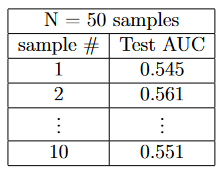

### From this table, you can calculate the mean and standard deviation of the test AUC for N samples.

In [12]:
Sample = pd.DataFrame(columns = ['Sample #'])
def samples(N):
    df = pd.DataFrame()
    Test = pd.DataFrame(columns = ["Test AUC"])
    for n in list(range(0,10)):
        
        xx = X_train_monthly.sample(N).index
        xy = X_test_monthly.sample(N, replace=True).index
        
        Xtrain = X_train_monthly.loc[xx]
        Xtest = X_test_monthly.loc[xy]
        ytrain = y_train_monthly.loc[xx]
        ytest = y_test_monthly.loc[xy]
        
        Simple_Tree = DecisionTreeClassifier(criterion = 'gini', 
                                   max_depth = 8, 
#                                    min_samples_split = 1300,
#                                    min_samples_leaf = 28100,
                                   class_weight = 'balanced',
                                   ccp_alpha = 0.0054)
        Simple_Tree  = Simple_Tree.fit(Xtrain, ytrain)

#         Random_Forest = RandomForestClassifier(n_estimators = 18, 
#                                                criterion = 'gini', 
#                                                max_depth = 9,
#                                                min_samples_split = 2,
#                                                min_samples_leaf = 1,
#                                                class_weight = 'balanced',
#                                                ccp_alpha = 0.0001)
#         Random_Forest = Random_Forest.fit(Xtrain, ytrain)
        
        # Scores for train set
        scores_train = Simple_Tree.predict_proba(Xtrain)[:, 1]
        # Scores for test set
        scores_test = Simple_Tree.predict_proba(Xtest)[:, 1]
        
        # ROC Calc Train set
        fpr_train, tpr_train, _ = roc_curve(ytrain, scores_train)
        # ROC Calc Test set
        fpr_test, tpr_test, _ = roc_curve(ytest, scores_test)
        
        # AUC Calc
        auc_train = auc(fpr_train, tpr_train)
        # AUC Calc
        auc_test  = auc(fpr_test, tpr_test)
        auc_test = '%.3f'%auc_test
        
        Test.loc[len(Test)]  = auc_test
        Sample.loc[len(Sample)] = f'Sample {n}'
        df = pd.concat([Sample, Test], axis = 1)
    temp_np = pd.to_numeric(df['Test AUC'])
    df = df.set_index('Sample #')
    df.loc['Mean'] = '%.3f'%temp_np.mean()
    df.loc['Std. Dev.'] = '%.5f'%temp_np.std()

    return df

In [13]:
df50 = pd.DataFrame(samples(50))
df50

,Test AUC
Sample #,
Sample 0,0.488
Sample 1,0.438
Sample 2,0.656
Sample 3,0.601
Sample 4,0.396
Sample 5,0.444
Sample 6,0.698
Sample 7,0.458
Sample 8,0.567


## 3. Repeat the procedure you performed in the previous step for different sample size N (e.g. 100, 500, 1000, 2000, 5000, 10000) 

The sample sizes from 50 - 1000 were done with the exception of the min_sample_leaf and min_sample_split as the dat as the data size was too small.

In [14]:
df0 = pd.DataFrame(samples(26))
# df0

In [15]:
df100 = pd.DataFrame(samples(100))
# df100

In [16]:
df500 = pd.DataFrame(samples(500))
# df500

In [17]:
df1000 = pd.DataFrame(samples(1000))
# df1000

In [18]:
df2000 = pd.DataFrame(samples(2000))
# df2000

In [19]:
df5000 = pd.DataFrame(samples(5000))
# df5000

In [20]:
df10000 = pd.DataFrame(samples(10000))
# df10000

In [21]:
df30000 = pd.DataFrame(samples(30000))
# df30000

In [22]:
df50000 = pd.DataFrame(samples(50000))
# df50000

In [23]:
df100000 = pd.DataFrame(samples(100000))
# df100000

In [24]:
df150000 = pd.DataFrame(samples(150000))
# df150000

In [25]:
df200000 = pd.DataFrame(samples(200000))
# df200000

In [26]:
df250000 = pd.DataFrame(samples(250000))
# df250000

In [27]:
df260000 = pd.DataFrame(samples(260000))
# df260000

In [28]:
df270000 = pd.DataFrame(samples(270000))
# df270000

In [29]:
df280000 = pd.DataFrame(samples(280000))
# df280000

In [30]:
df290000 = pd.DataFrame(samples(290000))
# df290000

## 4. Build a table that contains the values of:

- **Sample size N**
- **Test AUC mean**
- **Test AUC standard deviation**

In [31]:
temp_df = {'Sample Size N' : ['50', '100', '500', '1000', '2000', '5000', '10000','30000', '50000', 
                              '100000', '150000', '200000', '250000',
                              '260000','270000','280000','290000'], 
            'Test AUC Mean' : [df50.loc['Mean']['Test AUC'],
                               df100.loc['Mean']['Test AUC'],
                               df500.loc['Mean']['Test AUC'],
                               df1000.loc['Mean']['Test AUC'],
                               df2000.loc['Mean']['Test AUC'],
                               df5000.loc['Mean']['Test AUC'],
                               df10000.loc['Mean']['Test AUC'],
                               df30000.loc['Mean']['Test AUC'],
                               df50000.loc['Mean']['Test AUC'],
                               df100000.loc['Mean']['Test AUC'],
                               df150000.loc['Mean']['Test AUC'],
                               df200000.loc['Mean']['Test AUC'],
                               df250000.loc['Mean']['Test AUC'],
                               df260000.loc['Mean']['Test AUC'],
                               df270000.loc['Mean']['Test AUC'],
                               df280000.loc['Mean']['Test AUC'],
                               df290000.loc['Mean']['Test AUC']], 
           'Test AUC Std_Dev' : [df50.loc['Std. Dev.']['Test AUC'],
                                 df100.loc['Std. Dev.']['Test AUC'],
                                 df500.loc['Std. Dev.']['Test AUC'],
                                 df1000.loc['Std. Dev.']['Test AUC'],
                                 df2000.loc['Std. Dev.']['Test AUC'],
                                 df5000.loc['Std. Dev.']['Test AUC'],
                                 df10000.loc['Std. Dev.']['Test AUC'],
                                 df30000.loc['Std. Dev.']['Test AUC'],
                                 df50000.loc['Std. Dev.']['Test AUC'],
                                 df100000.loc['Std. Dev.']['Test AUC'],
                                 df150000.loc['Std. Dev.']['Test AUC'],
                                 df200000.loc['Std. Dev.']['Test AUC'],
                                 df250000.loc['Std. Dev.']['Test AUC'],
                                 df260000.loc['Std. Dev.']['Test AUC'],
                                 df270000.loc['Std. Dev.']['Test AUC'],
                                 df280000.loc['Std. Dev.']['Test AUC'],
                                 df290000.loc['Std. Dev.']['Test AUC']]}
Final_table = pd.DataFrame(temp_df)
# Final_table.set_index('Sample Size N', inplace=True)
Final_table.dtypes

Sample Size N       object
Test AUC Mean       object
Test AUC Std_Dev    object
dtype: object

## 5. Using the matplotlib function [errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html), plot the model performance captured in the test AUC mean and standard deviation as a function of the sample size. From this plot, can you estimate what is the minimum number of samples needed to model the behaviour adequately?

In [32]:
Final_table['Test AUC Mean'] = Final_table['Test AUC Mean'].astype(float)
Final_table['Test AUC Std_Dev'] = Final_table['Test AUC Std_Dev'].astype(float)
Final_table

,Sample Size N,Test AUC Mean,Test AUC Std_Dev
0,50,0.520,0.10317
1,100,0.518,0.06565
2,500,0.541,0.03752
3,1000,0.537,0.03555
4,2000,0.585,0.01787
5,5000,0.592,0.01494
6,10000,0.596,0.01493
7,30000,0.607,0.01634
8,50000,0.592,0.01476
9,100000,0.589,0.01027


Text(0.5, 1.0, 'AUC v/s Sample Size')

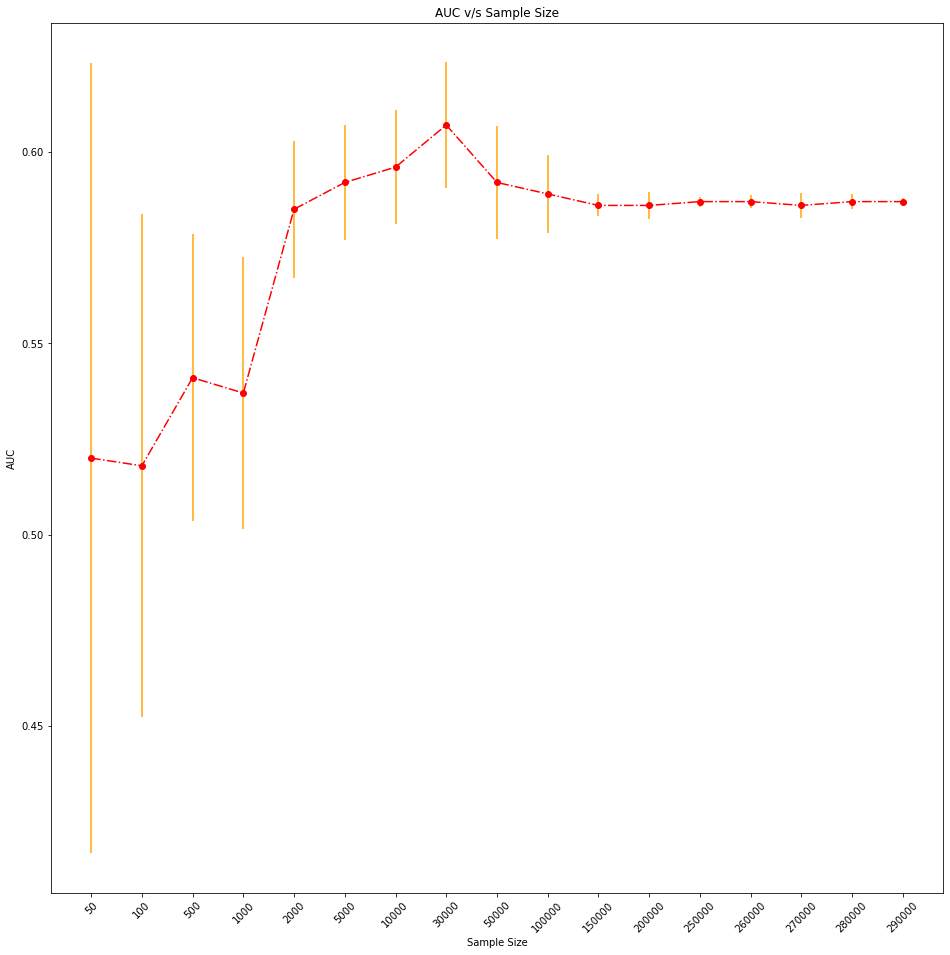

In [33]:
x = Final_table['Sample Size N']
y = Final_table['Test AUC Mean']
yerror = Final_table['Test AUC Std_Dev']

plt.errorbar(x,
             y,
             yerr=yerror,
             xerr=None,
             fmt='-.ro',
             ecolor='orange')
plt.xlabel('Sample Size')
plt.xticks(rotation = 45)
plt.ylabel('AUC')
plt.title('AUC v/s Sample Size')